## Build a basic chatbot with Langgraph (GRAPH API) 🤖

### Components of Langgraph
1. Edges
2. Nodes
3. States

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv

load_dotenv()

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [ ]:
llm = init_chat_model(
    "azure_openai:gpt-4o-mini",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
)

In [ ]:
# Node definition for the chatbot
# This node will use the LLM to generate a response based on the messages in the state
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Create a StateGraph instance
# This graph will manage the state and the flow of the chatbot
graph_builder = StateGraph(State)

# Adding node to the graph
graph_builder.add_node("llmchatbot", chatbot)

# Adding an START edge
graph_builder.add_edge(START, "llmchatbot")

# Adding an END edge
graph_builder.add_edge("llmchatbot", END) 

# Compile the graph to create a runnable chatbot
# The compiled graph can be invoked, streamed, and used in various ways
graph = graph_builder.compile()

In [ ]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [ ]:
# Invoke the graph with a message

response = graph.invoke(
    {
        "messages": "hi, how are you doing today?"
    }
)

response["messages"][-1].content  # Get the last message content from the response

In [ ]:
# Stream the graph to get real-time responses

for event in graph.stream(
    {
        "messages": "hi, how are you doing today?"
    }
):
    for value in event.values():
        print(value["messages"][-1].content)  # Print the last message content from each event

### Chatbot with Tool calling

In [ ]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(max_results=1)
tavily_search_tool.invoke("What is the capital of France?")

def multiply(a: int, b: int) -> int:
    """
    Multiplies two integers and returns the result.
    
    Args:
        a (int): The first integer.
        b (int): The second integer.
        
    Returns:
        int: The product of the two integers.
    """
    return a * b
    
tools = [tavily_search_tool, multiply]

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

llm_with_tool = llm.bind_tools(tools) # Bind the tools to the LLM

def chatbot_with_tool(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_with_tool", chatbot_with_tool)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "chatbot_with_tool")
graph_builder.add_conditional_edges("chatbot_with_tool", tools_condition) # If the LLM response contains a tool call, go to the tools node. Otherwise, go to END
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()

response = graph.invoke(
    {
        "messages": "Can you get me the latest news about AI? and multiply 3 and 4?"
    }
)

for msg in response["messages"]:
    msg.pretty_print()


In [ ]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

### ReAct Agent Architecture

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

llm_with_tool = llm.bind_tools(tools) # Bind the tools to the LLM

def chatbot_with_tool(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_with_tool", chatbot_with_tool)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "chatbot_with_tool")
graph_builder.add_conditional_edges("chatbot_with_tool", tools_condition) # If the LLM response contains a tool call, go to the tools node. Otherwise, go to END
graph_builder.add_edge("tools", "chatbot_with_tool")  # Loop back to chatbot_with_tool for further processing

graph = graph_builder.compile()

response = graph.invoke(
    {
        "messages": "Can you get me the latest cricket score between India and England? and multiply 3 and 4?"
    }
)

for msg in response["messages"]:
    msg.pretty_print()

In [ ]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

### Adding Memory in Agentic Graph

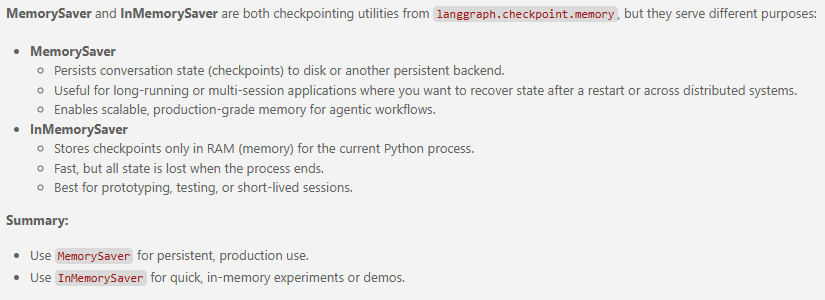

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory_saver = MemorySaver()

llm_with_tool = llm.bind_tools(tools) # Bind the tools to the LLM

def chatbot_with_tool(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_with_tool", chatbot_with_tool)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "chatbot_with_tool")
graph_builder.add_conditional_edges("chatbot_with_tool", tools_condition) # If the LLM response contains a tool call, go to the tools node. Otherwise, go to END
graph_builder.add_edge("tools", "chatbot_with_tool")  # Loop back to chatbot_with_tool for further processing

graph = graph_builder.compile(checkpointer=memory_saver) # Compile the graph with memory saver

response = graph.invoke(
    {
        "messages": "Hi, my name is Chandan."
    },
    {
        "configurable": {
            "thread_id": "1"
        }
    }
)

for msg in response["messages"]:
    msg.pretty_print()

### Streaming

Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state:
- **Values**: The current state or output at each step of the graph as it streams. Think of it as a snapshot of the latest results.
- **Updates**: The changes or differences in the state since the last step. This helps you track what has changed during streaming, rather than seeing the whole state every time.

In [ ]:
for chunk in graph.stream(
        {
            "messages": "Who is Virat Kohli?"
        },
        {
            "configurable": {
                "thread_id": "2"
            }
        },
        stream_mode="updates" # updates
    ):
    print(chunk)

In [ ]:
for chunk in graph.stream(
        {
            "messages": "Who is Virat Kohli?"
        },
        {
            "configurable": {
                "thread_id": "2"
            }
        },
        stream_mode="values" # values
    ):
    print(chunk)

In [ ]:
# Async streaming of events

async for event in graph.astream_events(
        {
            "messages": "Who is Virat Kohli?"
        },
        {
            "configurable": {
                "thread_id": "2"
            }
        },
        version="v2"
    ):
    print(event)

### Human in the Loop

In [ ]:

import os
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv

load_dotenv()

# 1. Define a tool that requests human approval via interrupt()
def book_hotel(hotel_name: str):
    """Book a hotel, but ask a human to approve or edit first."""
    
    response = interrupt(
        f"Attempting to book hotel: {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    
    print(f"Human response: {response}")
    
    # Handle the three possible human responses
    if response["type"] == "accept":
        # Human approved; proceed unchanged
        pass
    elif response["type"] == "edit":
        # Human edited the arguments
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unsupported response type: {response['type']}")
    
    return f"Successfully booked a stay at {hotel_name}."

# 2. Set up state persistence so the agent can pause and resume
checkpointer = InMemorySaver()

# 3. Create an agent that uses our HIL-enabled tool
agent = create_react_agent(
    model="azure_openai:gpt-4o-mini",
    tools=[book_hotel],
    checkpointer=checkpointer,
)

config = {"configurable": {"thread_id": "1"}}

# 4. Start streaming until we see the interrupt tool call
stream = agent.stream(
    {"messages": [{"role": "user", "content": "Book a stay at McKittrick hotel"}]},
    config
)

# 5. Read the stream until we hit the interrupt
for chunk in stream:
    print(chunk)
    # when we hit the interrupt, stop reading further
    if chunk.get("tool") == "interrupt":
        break

# 6. Now pause and await the human decision:
resp = input("❓ Approve booking? (type 'accept' or 'edit'): ").strip().lower()

if resp == "accept":
    resume = Command(resume={"type": "accept"})
else:
    new_name = input("✏️  New hotel_name: ").strip()
    resume = Command(resume={"type": "edit", "args": {"hotel_name": new_name}})

# 7. Resume the rest of the stream
for chunk in agent.stream(resume, config):
    print(chunk)

In [ ]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")